### kaggle要求notebook文件且不能联网，所以需要用到的未原装包要自行放到kaggle dataset里，再用sys.path.append()添加路径

In [1]:
import sys
sys.path.append('../input/labnn/labml-nn')
sys.path.append('../input/labnn/helpers')
sys.path.append('../input/sk-image/scikit-image-main')


In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import collections
from PIL import Image
from torchvision import transforms
from torchvision import transforms as T
from torch.autograd import Variable
import torch.nn.functional as F

from labml_helpers.module import Module
from labml_nn.utils import clone_module_list

from skimage.measure import label
from skimage.transform import resize
from skimage.morphology import dilation
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects
from typing import Optional, Union, List, Tuple

In [3]:
WIDTH = 704
HEIGHT = 520

BATCH_SIZE = 32

PATCH_SIZE = 280

TEST_CSV = "../input/sartorius-cell-instance-segmentation/sample_submission.csv"
TEST_PATH = "../input/sartorius-cell-instance-segmentation/test" # guanhui
RESULT_DIR = "./" 
LOG_PATH = './exp.log'

PRETRAIN_MODEL = '../input/cell-pretrain-model/new_model.pth'

## DATASET

In [4]:

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

class CellDataset_submit(Dataset):
    def __init__(self, image_dir, df, transforms=None, patch_size=16):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.patch_size = patch_size
        self.height = HEIGHT
        self.width = WIDTH
        
        if self.height % self.patch_size !=0:
            self.row_sum = self.height // self.patch_size +1
        else:
            self.row_sum = self.height // self.patch_size
        if self.width % self.patch_size !=0:
            self.col_sum = self.width // self.patch_size+1
        else:
            self.col_sum = self.width // self.patch_size
        
        self.patch_num = self.row_sum * self.col_sum

        self.image_info = collections.defaultdict(dict)
#         temp_df_11 = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()

#         train_df, val_df = train_test_split(temp_df_11, test_size=0.2, random_state=42)
        temp_df = self.df

        ## 将id, path, annotation转成字典
        ii = 0
        for index, row in temp_df.iterrows():
            self.image_info[ii] = {
                'image_id': row['id'],
                'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
            }
            ii += 1

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        img_pad = np.zeros((self.row_sum * self.patch_size , self.col_sum * self.patch_size))
        img_idx = idx // self.patch_num
        patch_idx = idx % self.patch_num

        img_path = self.image_info[img_idx]["image_path"]
        img_name = self.image_info[img_idx]['image_id']
        img = Image.open(img_path)

        info = self.image_info[img_idx]
        img = np.array(img)
        img_pad[:520,:704] = img
        img_pad = normalization(img_pad)

        # 计算patch位置
        cur_row = patch_idx // self.col_sum
        cur_col = patch_idx % self.col_sum
        
        start_row = cur_row * self.patch_size
        end_row = start_row + self.patch_size
        start_col = cur_col * self.patch_size
        end_col = start_col + self.patch_size
        
        # 切片
        image_clip = img_pad[start_row:end_row, start_col:end_col]

        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        image_clip = transform(image_clip)

        image_clip = torch.as_tensor(image_clip, dtype=torch.float)
        
        return image_clip,img_name

    def __len__(self):
        return len(self.image_info) * self.patch_num


In [5]:

class First2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, dropout=False):
        super(First2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)


class Encoder2D(nn.Module):
    def __init__(
            self, in_channels, middle_channels, out_channels,
            dropout=False, downsample_kernel=2
    ):
        super(Encoder2D, self).__init__()

        layers = [
            nn.MaxPool2d(kernel_size=downsample_kernel),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


class Center2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Center2D, self).__init__()

        layers = [
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.center = nn.Sequential(*layers)

    def forward(self, x):
        return self.center(x)


class Decoder2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Decoder2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class Last2D(nn.Module):
    def __init__(self, in_channels, middle_channels, softmax=False):
        super(Last2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=1),
        ]

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)

In [6]:

class ConvMixerLayer(Module):
    """
    <a id="ConvMixerLayer"></a>
    ## ConvMixer layer
    This is a single ConvMixerLayer layer. The model will have a series of these.
    """

    def __init__(self, d_model: int, kernel_size: int):
        """
        * `d_model` is the number of channels in patch embeddings, $h$
        * `kernel_size` is the size of the kernel of spatial convolution, $k$
        """
        super().__init__()
        # Depth-wise convolution is separate convolution for each channel.
        # We do this with a convolution layer with the number of groups equal to the number of channels.
        # So that each channel is it's own group.
        self.depth_wise_conv = nn.Conv2d(d_model, d_model,
                                         kernel_size=kernel_size,
                                         groups=d_model,
                                         padding=(kernel_size - 1) // 2)
        # Activation after depth-wise convolution
        self.act1 = nn.GELU()
        # Normalization after depth-wise convolution
        self.norm1 = nn.BatchNorm2d(d_model)

        # Point-wise convolution is a $1 \times 1$ convolution.
        # i.e. a linear transformation of patch embeddings
        self.point_wise_conv = nn.Conv2d(d_model, d_model, kernel_size=1)
        # Activation after point-wise convolution
        self.act2 = nn.GELU()
        # Normalization after point-wise convolution
        self.norm2 = nn.BatchNorm2d(d_model)

    def forward(self, x: torch.Tensor):
        # For the residual connection around the depth-wise convolution
        residual = x

        # Depth-wise convolution, activation and normalization
        x = self.depth_wise_conv(x)
        x = self.act1(x)
        x = self.norm1(x)

        # Add residual connection
        x += residual

        # Point-wise convolution, activation and normalization
        x = self.point_wise_conv(x)
        x = self.act2(x)
        x = self.norm2(x)
        #
        return x

class PatchEmbeddings(Module):
    """
    <a id="PatchEmbeddings"></a>
    ## Get patch embeddings
    This splits the image into patches of size $p \times p$ and gives an embedding for each patch.
    """

    def __init__(self, d_model: int, patch_size: int, in_channels: int):
        """
        * `d_model` is the number of channels in patch embeddings $h$
        * `patch_size` is the size of the patch, $p$
        * `in_channels` is the number of channels in the input image (3 for rgb)
        """
        super().__init__()

        # We create a convolution layer with a kernel size and and stride length equal to patch size.
        # This is equivalent to splitting the image into patches and doing a linear
        # transformation on each patch.
        self.conv = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        # Activation function
        self.act = nn.GELU()
        # Batch normalization
        self.norm = nn.BatchNorm2d(d_model)

    def forward(self, x: torch.Tensor):
        """
        * `x` is the input image of shape `[batch_size, channels, height, width]`
        """
        # Apply convolution layer
        x = self.conv(x)
        # Activation and normalization
        x = self.act(x)
        x = self.norm(x)

        #
        return x


class UNet2D(nn.Module):
    def __init__(self, in_channels, conv_depths=(64, 128, 256, 512, 1024)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'

        super(UNet2D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First2D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder2D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder2D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last2D(conv_depths[1], conv_depths[0]))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center2D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):
        x_enc = [x]
        for enc_layer in self.encoder_layers:
            x_enc.append(enc_layer(x_enc[-1]))

        x_dec = [self.center(x_enc[-1])]
        for dec_layer_idx, dec_layer in enumerate(self.decoder_layers):
            x_opposite = x_enc[-1-dec_layer_idx]
            x_cat = torch.cat(
                [pad_to_shape(x_dec[-1], x_opposite.shape), x_opposite],
                dim=1
            )
            x_dec.append(dec_layer(x_cat))

        if not return_all:
            return x_dec[-1]
        else:
            return x_enc + x_dec


def pad_to_shape(this, shp):
    """
    Pads this image with zeroes to shp.
    Args:
        this: image tensor to pad
        shp: desired output shape
    Returns:
        Zero-padded tensor of shape shp.
    """
    if len(shp) == 4:
        pad = (0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    elif len(shp) == 5:
        pad = (0, shp[4] - this.shape[4], 0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    return F.pad(this, pad)


class ClassificationHead(Module):
    """
    <a id="ClassificationHead"></a>
    ## Classification Head
    They do average pooling (taking the mean of all patch embeddings) and a final linear transformation
    to predict the log-probabilities of the image classes.
    """

    def __init__(self, d_model: int):
        """
        * `d_model` is the number of channels in patch embeddings, $h$
        * `n_classes` is the number of classes in the classification task
        """
        super().__init__()
        # Average Pool
        # self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.convtrans1 = nn.ConvTranspose2d(d_model, d_model, kernel_size=4, stride=2, padding=1)
        self.act1 = nn.GELU()
        self.batchnorm1 = nn.BatchNorm2d(d_model)

        self.convtrans2 = nn.ConvTranspose2d(d_model, d_model, kernel_size=4, stride=2, padding=1)
        self.act2 = nn.GELU()
        self.batchnorm2 = nn.BatchNorm2d(d_model)

        self.convtrans3 = nn.ConvTranspose2d(d_model, d_model, kernel_size=4, stride=2, padding=1)
        self.act3 = nn.GELU()
        self.batchnorm3 = nn.BatchNorm2d(d_model)
        #这里尽量不要考虑上采用函数，因为这个线性插值的纯粹的数值计算是不能学习的，反卷积可以做到上采样
        # self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        #1*1卷积这里，无论前面输出多好channel， 这里直接拿来作为输入就行了
        self.conv = nn.Conv2d(d_model, 64, kernel_size=1, stride=1, padding=0)
        #由于目前用的交叉商函数自带softmax， 所以这里就不需要加入softmax了
        # Linear layer
        # self.linear = nn.Linear(d_model, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        # Average pooling
        # x = self.pool(x)
        x = self.convtrans1(x)
        x = self.act1(x)
        x = self.batchnorm1(x)

        x = self.convtrans2(x)
        x = self.act2(x)
        x = self.batchnorm2(x)

        x = self.convtrans3(x)
        x = self.act3(x)
        x = self.batchnorm3(x)

        x = self.conv(x)
        # x = self.upsample(x)
        # Get the embedding, `x` will have shape `[batch_size, d_model, 1, 1]`
        # x = x[:, :, 0, 0]
        # Linear layer
        # x = self.linear(x)

        # print(x)
        # print('*'*25)
        # x = self.adjust(x)
        # x = self.softmax(x)
        # print(x.shape)
        # print(x)

        #
        return x


class Segmentation(Module):

    def __init__(self, d_model: int):
        super().__init__()
        self.adjust = nn.Conv2d(d_model, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x: torch.Tensor):
        x = self.adjust(x)

        return x


class ConvUnetMixer(Module):
    """
    ## ConvMixer
    This combines the patch embeddings block, a number of ConvMixer layers and a classification head.
    """
    def __init__(self, conv_mixer_layer: ConvMixerLayer, n_layers: int,
                 patch_emb: PatchEmbeddings,
                 unet: UNet2D,
                 classification: ClassificationHead,
                 segmentation: Segmentation):
        """
        * `conv_mixer_layer` is a copy of a single [ConvMixer layer](#ConvMixerLayer).
         We make copies of it to make ConvMixer with `n_layers`.
        * `n_layers` is the number of ConvMixer layers (or depth), $d$.
        * `patch_emb` is the [patch embeddings layer](#PatchEmbeddings).
        * `classification` is the [classification head](#ClassificationHead).
        """
        super().__init__()
        # Patch embeddings
        self.patch_emb = patch_emb
        # Unet layer
        self.unet = unet
        # Segmentation layer
        self.classification = classification
        self.segmentation = segmentation
        # Make copies of the [ConvMixer layer](#ConvMixerLayer)
        self.conv_mixer_layers = clone_module_list(conv_mixer_layer, n_layers)

    def forward(self, x: torch.Tensor):
        """
        * `x` is the input image of shape `[batch_size, channels, height, width]`
        """
        xin = x.clone()
        # Get patch embeddings. This gives a tensor of shape `[batch_size, d_model, height / patch_size, width / patch_size]`.
        x = self.patch_emb(x)

        # Pass through [ConvMixer layers](#ConvMixerLayer)
        for layer in self.conv_mixer_layers:
            x = layer(x)

        x = self.classification(x)

        x_u = self.unet(xin)

        x = x + x_u

        # Segmentation output
        x = self.segmentation(x)

        #
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
df_all = pd.read_csv(TEST_CSV)
test_dataset = CellDataset_submit(TEST_PATH, df_all, patch_size=280)
# batch_size must be 1 and shuffle must be False
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2) 


In [9]:
patch_size: int = 8
# Number of channels in patch embeddings, $h$
d_model: int = 256
# Number of [ConvMixer layers](#ConvMixerLayer) or depth, $d$
n_layers: int = 4
# Kernel size of the depth-wise convolution, $k$
kernel_size: int = 7
# Number of classes in the task
n_classes: int = 1
# conv_depths must have at least 3 members
conv_depths = (64, 128, 256, 512, 1024)
inchannel = 1

In [10]:
model = ConvUnetMixer(ConvMixerLayer(d_model, kernel_size), n_layers,
                          PatchEmbeddings(d_model, patch_size, 1),
                          UNet2D(inchannel, conv_depths),
                          ClassificationHead(d_model),
                          Segmentation(64)).to(device)

model.load_state_dict(torch.load(PRETRAIN_MODEL))
model = model.to(device)

In [11]:
## all predicted masks
predicted_masks_list=np.zeros((len(df_all),test_dataset.row_sum * test_dataset.patch_size,test_dataset.col_sum * test_dataset.patch_size)) 
predicted_contour_list=np.zeros((len(df_all),test_dataset.row_sum * test_dataset.patch_size,test_dataset.col_sum * test_dataset.patch_size)) 
# predicted_distance_list=np.zeros((len(df_all),test_dataset.row_sum * test_dataset.patch_size,test_dataset.col_sum * test_dataset.patch_size)) 
names = ['a' for i in range(len(df_all))]

In [12]:
patch_id = 0
img_id = 0
row_sums = test_dataset.row_sum
col_sums = test_dataset.col_sum
patch_nums = test_dataset.patch_num
model.eval()
with torch.no_grad():
    for batch_idx, (X_batch,y_name) in enumerate(test_loader): 
        X_batch = Variable(X_batch.to(device))
        y_out = model(X_batch)
        pre_mask = torch.sigmoid(y_out[0][0])
        pre_contour = torch.sigmoid(y_out[0][1])
#         pre_distance = torch.tanh(y_out[0][2])
        
        patch_id = batch_idx % patch_nums
        img_id = batch_idx // patch_nums
        
        cur_r = patch_id // col_sums
        cur_c = patch_id % col_sums

        start_r = cur_r * PATCH_SIZE
        end_r = start_r + PATCH_SIZE
        start_c = cur_c * PATCH_SIZE
        end_c = start_c + PATCH_SIZE
        
        predicted_masks_list[img_id, start_r:end_r, start_c:end_c] = pre_mask.cpu()
        predicted_contour_list[img_id, start_r:end_r, start_c:end_c] = pre_contour.cpu()
#         predicted_distance_list[img_id, start_r:end_r, start_c:end_c] = pre_distance.cpu()
        names[img_id] = y_name[0]

        

In [13]:
predicted_masks_list = predicted_masks_list[:,:520,:704]
predicted_contour_list = predicted_contour_list[:,:520,:704]
# predicted_distance_list = predicted_distance_list[:,:520,:704]

In [14]:
predicted_masks_list = np.where(predicted_masks_list>0.5,1,0)

<function matplotlib.pyplot.show(close=None, block=None)>

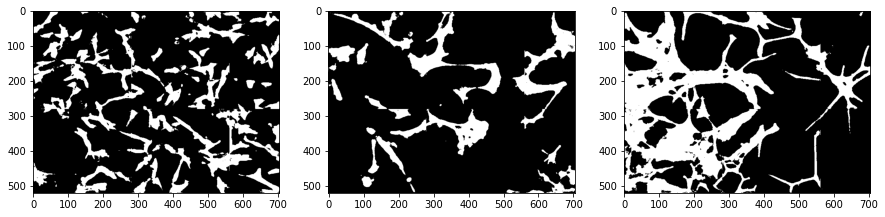

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(predicted_masks_list[0][:520,:704],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(predicted_masks_list[1][:520,:704],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(predicted_masks_list[2][:520,:704],cmap='gray')
plt.show

In [16]:
# predicted_contour_list = np.where(predicted_contour_list>0.2,1,0)

<function matplotlib.pyplot.show(close=None, block=None)>

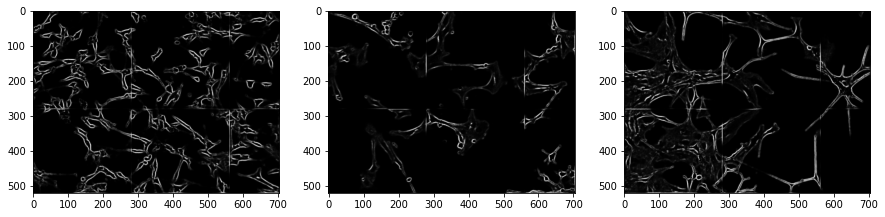

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(predicted_contour_list[0][:520,:704],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(predicted_contour_list[1][:520,:704],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(predicted_contour_list[2][:520,:704],cmap='gray')
plt.show

In [18]:
# plt.figure(figsize=(15,15))
# plt.subplot(1,3,1)
# plt.imshow(predicted_distance_list[0][:520,:704],cmap='gray')
# plt.subplot(1,3,2)
# plt.imshow(predicted_distance_list[1][:520,:704],cmap='gray')
# plt.subplot(1,3,3)
# plt.imshow(predicted_distance_list[2][:520,:704],cmap='gray')
# plt.show

In [19]:

# 调用此函数时直接 bcd_watershed(img)即可，img是模型输出的3通道图片
def bcd_watershed(img, thres1=0.9, thres2=0.8, thres3=0.85, thres4=0.5, thres5=0.0, thres_small=16,
                  scale_factors=(1.0, 1.0), remove_small_mode='background', seed_thres=32, return_seed=False):
    r"""Convert binary foreground probability maps, instance contours and signed distance
        transform to instance masks via watershed segmentation algorithm.

        Note:
            This function uses the `skimage.segmentation.watershed <https://github.com/scikit-image/scikit-image/blob/master/skimage/segmentation/_watershed.py#L89>`_
            function that converts the input image into ``np.float64`` data type for processing. Therefore please make sure enough memory is allocated when handling large arrays.

        Args:
            img (numpy.ndarray): foreground and contour probability of shape :math:`(C, Y, X)`.
            thres1 (float): threshold of seeds. Default: 0.9
            thres2 (float): threshold of instance contours. Default: 0.8
            thres3 (float): threshold of foreground. Default: 0.85
            thres4 (float): threshold of signed distance for locating seeds. Default: 0.5
            thres5 (float): threshold of signed distance for foreground. Default: 0.0
            thres_small (int): size threshold of small objects to remove. Default: 16
            scale_factors (tuple): scale factors for resizing in :math:`( Y, X)` order. Default: ( 1.0, 1.0)
            remove_small_mode (str): ``'background'``, ``'neighbor'`` or ``'none'``. Default: ``'background'``
        """
    assert img.shape[0] == 3 # channel = 3
    semantic, boundary, distance = img[0], img[1], img[2]
    distance = (distance / 255.0) * 2.0 - 1.0

    seed_map = (semantic > int(255 * thres1)) * (boundary < int(255 * thres2)) * (distance > thres4)
    foreground = (semantic > int(255 * thres3)) * (distance > thres5)
    seed = label(seed_map)  # 生成连通图，用数字0-n表示，相通的标为同一类，不通的为不同类。这里默认参数似乎是判断上下左右4个像素是否联通。可选8像素
    seed = remove_small_objects(seed, seed_thres)  # 第二个是mini_size
    segm = watershed(-semantic.astype(np.float64), seed, mask=foreground)
    segm = remove_small_instances(segm, thres_small, remove_small_mode)

    if not all(x == 1.0 for x in scale_factors):
        target_size = (int(semantic.shape[0] * scale_factors[0]),
                       int(semantic.shape[1] * scale_factors[1]),
                       int(semantic.shape[2] * scale_factors[2]))
        segm = resize(segm, target_size, order=0, anti_aliasing=False, preserve_range=True)

    if not return_seed:
        return cast2dtype(segm)

    return cast2dtype(segm), seed


def bc_watershed(volume, thres1=0.9, thres2=0.8, thres3=0.85, thres_small=128, scale_factors=(1.0, 1.0, 1.0),
                 remove_small_mode='background', seed_thres=32):
    r"""Convert binary foreground probability maps and instance contours to
    instance masks via watershed segmentation algorithm.

    Note:
        This function uses the `skimage.segmentation.watershed <https://github.com/scikit-image/scikit-image/blob/master/skimage/segmentation/_watershed.py#L89>`_
        function that converts the input image into ``np.float64`` data type for processing. Therefore please make sure enough memory is allocated when handling large arrays.

    Args:
        volume (numpy.ndarray): foreground and contour probability of shape :math:`(C, Z, Y, X)`.
        thres1 (float): threshold of seeds. Default: 0.9
        thres2 (float): threshold of instance contours. Default: 0.8
        thres3 (float): threshold of foreground. Default: 0.85
        thres_small (int): size threshold of small objects to remove. Default: 128
        scale_factors (tuple): scale factors for resizing in :math:`(Z, Y, X)` order. Default: (1.0, 1.0, 1.0)
        remove_small_mode (str): ``'background'``, ``'neighbor'`` or ``'none'``. Default: ``'background'``
    """
    assert volume.shape[0] == 2
    semantic = volume[0]
    boundary = volume[1]
    seed_map = (semantic > int(255 * thres1)) * (boundary < int(255 * thres2))
    foreground = (semantic > int(255 * thres3))
    seed = label(seed_map)
    seed = remove_small_objects(seed, seed_thres)
    segm = watershed(-semantic.astype(np.float64), seed, mask=foreground)
    segm = remove_small_instances(segm, thres_small, remove_small_mode)

    if not all(x == 1.0 for x in scale_factors):
        target_size = (int(semantic.shape[0] * scale_factors[0]),
                       int(semantic.shape[1] * scale_factors[1]),
                       int(semantic.shape[2] * scale_factors[2]))
        segm = resize(segm, target_size, order=0, anti_aliasing=False, preserve_range=True)

    return cast2dtype(segm)


def remove_small_instances(segm: np.ndarray,
                           thres_small: int = 128,
                           mode: str = 'background'):
    """Remove small spurious instances.
    """
    assert mode in ['none',
                    'background',
                    'background_2d',
                    'neighbor',
                    'neighbor_2d']

    if mode == 'none':
        return segm

    if mode == 'background':
        return remove_small_objects(segm, thres_small)
    elif mode == 'background_2d':
        temp = [remove_small_objects(segm[i], thres_small)
                for i in range(segm.shape[0])]
        return np.stack(temp, axis=0)

    if mode == 'neighbor':
        return merge_small_objects(segm, thres_small, do_3d=True)
    elif mode == 'neighbor_2d':
        temp = [merge_small_objects(segm[i], thres_small)
                for i in range(segm.shape[0])]
        return np.stack(temp, axis=0)


def merge_small_objects(segm, thres_small, do_3d=False):
    struct = np.ones((1,3,3)) if do_3d else np.ones((3,3))
    indices, counts = np.unique(segm, return_counts=True)

    for i in range(len(indices)):
        idx = indices[i]
        if counts[i] < thres_small:
            temp = (segm == idx).astype(np.uint8)
            coord = bbox_ND(temp, relax=2)
            cropped = crop_ND(temp, coord)

            diff = dilation(cropped, struct) - cropped
            diff_segm = crop_ND(segm, coord)
            diff_segm[np.where(diff==0)]=0

            u, ct = np.unique(diff_segm, return_counts=True)
            if len(u) > 1 and u[0] == 0:
                u, ct = u[1:], ct[1:]

            segm[np.where(segm==idx)] = u[np.argmax(ct)]

    return segm


def cast2dtype(segm):
    """Cast the segmentation mask to the best dtype to save storage.
    """
    max_id = np.amax(np.unique(segm))
    m_type = getSegType(int(max_id))
    return segm.astype(m_type)


def getSegType(mid):
    # reduce the label dtype
    m_type = np.uint64
    if mid < 2**8:
        m_type = np.uint8
    elif mid < 2**16:
        m_type = np.uint16
    elif mid < 2**32:
        m_type = np.uint32
    return m_type


def crop_ND(img: np.ndarray, coord: Tuple[int]) -> np.ndarray:
    N = img.ndim
    assert len(coord) == N * 2
    slicing = []
    for i in range(N):
        slicing.append(slice(coord[2*i], coord[2*i+1]))
    slicing = tuple(slicing)
    return img[slicing].copy()


def bbox_ND(img: np.ndarray, relax: int = 0) -> tuple:
    """Calculate the bounding box of an object in a N-dimensional
    numpy array. All non-zero elements are treated as foregounrd.
    Reference: https://stackoverflow.com/a/31402351

    Args:
        img (np.ndarray): a N-dimensional array with zero as background.

    Returns:
        tuple: N-dimensional bounding box coordinates.
    """
    N = img.ndim
    out = []
    for ax in itertools.combinations(reversed(range(N)), N - 1):
        nonzero = np.any(img, axis=ax)
        out.extend(np.where(nonzero)[0][[0, -1]])

    return bbox_relax(out, img.shape, relax)


def bbox_relax(coord: Union[tuple, list],
               shape: tuple,
               relax: int = 0) -> tuple:

    assert len(coord) == len(shape) * 2
    coord = list(coord)
    for i in range(len(shape)):
        coord[2*i] = max(0, coord[2*i]-relax)
        coord[2*i+1] = min(shape[i], coord[2*i+1]+relax)

    return tuple(coord)

In [20]:
mask_contour=np.zeros((len(df_all),2,520,704)) 
for i in range(len(df_all)):
    mask_contour[i][0] = predicted_masks_list[i]
    mask_contour[i][1] = predicted_contour_list[i]
mask_contour = mask_contour * 255
del predicted_masks_list
del predicted_contour_list
watershed_result = np.zeros((len(df_all),520,704)) 
for i in range(len(df_all)):
    watershed_result[i] = bc_watershed(mask_contour[i], thres1=0.6, thres2=0.6, thres3=0.6, thres_small=32, scale_factors=(1.0, 1.0, 1.0),
                 remove_small_mode='background', seed_thres=16)


In [21]:
def rle_encode(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [22]:
result = [[] for i in range(len(df_all)) ]
for p in range(len(df_all)):
    for i in range(1,int(watershed_result[p].max())+1):
        temp = np.where(watershed_result[p]==i,1,0)
        if temp.sum() == 0:
            continue
        encode = rle_encode(temp)
        result[p].append(encode)
    

In [23]:
submit = []
for i in range(len(df_all)):
    for j in range(len(result[i])):
        submit.append([names[i], result[i][j]])


In [24]:
import pandas as pd 
col_name = ['id','predicted']
test=pd.DataFrame(data=submit,index=None,columns=col_name)#数据有三列，列名分别为one,two,three
test
test.to_csv('./submission.csv',index=False)

In [25]:
# x2=np.zeros((3,test_dataset.row_sum * test_dataset.patch_size,test_dataset.col_sum * test_dataset.patch_size)) 
# x2[0] = predicted_masks_list[0]
# x2[1] = predicted_contour_list[0]
# x2 = x2*255
# x2[2] = predicted_distance_list[0]

# x2 = bcd_watershed(x2)


In [26]:
# plt.imshow(x2[:520,:704],cmap='jet')
# plt.show()

# predicting on test set is finish, waiting for next step